# Latent Semantic Analysis & Latent Dirichlet Allocation
---
Perform Latent Semantic Analysis (AKA latent semantic indexing) & Latent Dirichlet Allocation (LDiA) on a spam dataset and compare results.

> You shall know a word by the company it keeps
> 
> \- J.R. Firth

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize.casual import casual_tokenize
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation as LDiA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
%matplotlib inline

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Seaborn version:', sns.__version__)

Pandas version: 0.22.0
Numpy version: 1.12.1
Seaborn version: 0.8.1


## Load Data

In [2]:
# Load data
sms = pd.read_csv('sms-spam.csv', index_col=0)

print("Data shape:", sms.shape)
print('Number of spam emails:', sms['spam'].sum())
print('{:.2f}% of emails are spam'.format(100. * (sms['spam'].sum() / len(sms))))

sms.head()

Data shape: (4837, 2)
Number of spam emails: 638
13.19% of emails are spam


,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Print some sample text
for idx, sample in sms.sample(5).iterrows():
    print("Spam ", sample['spam'], ":", sample['text'])

Spam  0 : Shall i get my pouch?
Spam  0 : Also maaaan are you missing out
Spam  1 : Jamster! To get your free wallpaper text HEART to 88888 now! T&C apply. 16 only. Need Help? Call 08701213186.
Spam  0 : I would but I'm still cozy. And exhausted from last night.nobody went to school or work. Everything is closed.
Spam  0 : I'm eatin now lor, but goin back to work soon... E mountain deer show huh... I watch b4 liao, very nice...


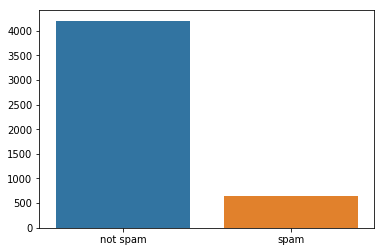

In [4]:
# Plot class distribution
sns.barplot(x=['not spam', 'spam'], y=[len(sms) - sms['spam'].sum(), sms['spam'].sum()])
plt.show()

## Vectorize Text
---
Use TfidfVectorizer to create bag of words (occurance counts) and then reweight counts with inverse document frequency values.

In [5]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf.fit_transform(raw_documents=sms['text']).toarray()

print(type(tfidf_docs))
print(tfidf_docs.shape)

<class 'numpy.ndarray'>
(4837, 9232)


Size of our vocabulary is 9,232 words or tokens. Now we have a **term-document matrix** (AKA **context matrix**). Each row is a document and each column is a term in our vocabulary.

## Perform LSA
---
Use sci-kit learn's PCA (principal component analysis) to perform latent semantic analysis. PCA uses singular value decomposition (SVD) to project high dimensional data onto a lower dimensional space. SVD produces 3 matrices (U, S, V) that multiplied together, give the original input matrix. SVD groups terms that have a high correlation and we can think of them as "topic" vectors.

* U: Left singular vectors
* S: Principal components (topics)
* V: Right singular vectors

The middle matrix is a diagonal matrix of singular values (AKA eigenvalues) and is the variance of each topic. In non-NLP problems it's known as the principal components of the input data. By keeping the principal components with high values we keep the dimensions that "explain" the original data. In NLP-speak this means that principal components with high values are our topics which are used a lot throughout our original corpus.

By truncating the size of SVD's output matrices, we can reduce the dimensionality. PCA does this for us when we set `n_components` as the number of topics we want (i.e. our new dimensionality).

In [6]:
# Use PCA to reduce dimensions
num_topics = 16
pca = PCA(n_components=num_topics)
pca = pca.fit(tfidf_docs)
topic_vectors = pca.transform(tfidf_docs)

print('Number of topics:', num_topics)
print('Shape of topic_vectors:', topic_vectors.shape)

Number of topics: 16
Shape of topic_vectors: (4837, 16)


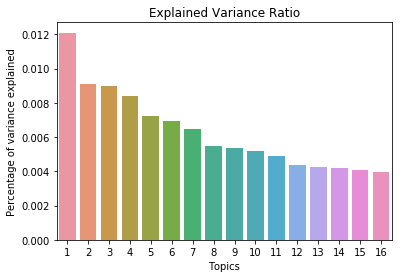

In [32]:
# Plot explained variance for each topic
sns.barplot(x=[i for i in range(1, pca.n_components_+1)], y=pca.explained_variance_ratio_)
plt.xlabel('Topics')
plt.ylabel('Percentage of variance explained')
plt.title('Explained Variance Ratio')
plt.show()

## Cosine Similarity
---
Here we can use the cosine similarity metric to measure the simliarity between two topic vectors. In this case we take the first 10 documents and compare their topic vectors against itself and the other 9 topic vectors. The cosine similarity is defined as:

K = **A** dot **B** / norm(A) \* norm(B)

When compared against itself, the similarity score should be 1 which indicates identical normalized vectors that point in the same direction along all dimensions. A similarity score closer to 1 means the two documents are similar to each other. A score of 0 means the two vectors are orthogonal to each other in all dimensions and are using different terms. A score closer to -1 means that are "opposite" of each other.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

index = ['spam' if x == 1 else 'not spam' for x in sms['spam'].iloc[:10]]
similar_df = pd.DataFrame(cosine_similarity(topic_vectors[:10], topic_vectors[:10]).round(1), index=index, columns=index)
similar_df

# Exactly the same as above
# topic_vectors = (topic_vectors.T / np.linalg.norm(topic_vectors, axis=1)).T
# topic_vectors[:10].dot(topic_vectors[:10].T).round(1)

,not spam,not spam,spam,not spam,not spam,spam,not spam,not spam,spam,spam
not spam,1.0,0.6,-0.1,0.7,0.0,-0.3,-0.2,-0.2,-0.3,-0.3
not spam,0.6,1.0,-0.1,0.8,-0.2,0.0,-0.2,-0.2,-0.2,-0.1
spam,-0.1,-0.1,1.0,-0.1,0.2,0.4,0.1,0.3,0.5,0.4
not spam,0.7,0.8,-0.1,1.0,-0.2,-0.3,-0.1,-0.3,-0.2,-0.1
not spam,0.0,-0.2,0.2,-0.2,1.0,0.2,-0.1,0.1,-0.3,-0.2
spam,-0.3,0.0,0.4,-0.3,0.2,1.0,-0.2,0.1,0.3,0.4
not spam,-0.2,-0.2,0.1,-0.1,-0.1,-0.2,1.0,0.2,-0.2,-0.1
not spam,-0.2,-0.2,0.3,-0.3,0.1,0.1,0.2,1.0,0.1,0.5
spam,-0.3,-0.2,0.5,-0.2,-0.3,0.3,-0.2,0.1,1.0,0.3
spam,-0.3,-0.1,0.4,-0.1,-0.2,0.4,-0.1,0.5,0.3,1.0


In the first row we can see that the cosine similarity for the first element is 1 because it is being compared against itself. It also gets high similarity scores for other "not spam" vectors (with some exceptions). We are able to show using cosine similarity that "not spam" vectors are similar to other "not spam" vectors and vice versa for "spam" vectors.

## Building & Evaluating a Classifier
---
Now we will use a linear discriminant analysis (LDA) classifier to try and classify our text samples as spam or ham.

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(topic_vectors, sms['spam'], test_size=0.3, random_state=21)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3385, 16)
X_test shape: (1452, 16)
y_train shape: (3385,)
y_test shape: (1452,)


In [9]:
# Create LDA model and fit to training data
clf = LDA()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [10]:
score = clf.score(X_test, y_test)

print("Test accuracy: {:.2f}%".format(100. * score))

Test accuracy: 96.07%


## Test Custom Emails
---
Let's create dummy emails and see if it can correctly classify them

In [129]:
emails = ["Hi John, this is Juan. Just wanted to let you know our meeting was rescheduled for next week. Will let you know more later. - Juan",
         "Earn $1000 a day. Work from home and make money with me. Reply to make money now!",
         "Earn £1000 a day. Work from home and make money with me. Reply to make money now!",
         "I'm going to be late, please order dinner tonight for everyone.",
         "Free money!! Join our network of professionls and get rewarded!"]
true_labels = [0, 1, 1, 0, 1]

emails_tfidf = tfidf.transform(emails).toarray()
emails_topic = pca.transform(emails_tfidf)
preds = clf.predict(emails_topic)
test_df = pd.DataFrame()
test_df['true'] = true_labels
test_df['preds'] = preds
test_df['email'] = emails
print(test_df)

   true  preds                                              email
0     0      0  Hi John, this is Juan. Just wanted to let you ...
1     1      0  Earn $1000 a day. Work from home and make mone...
2     1      1  Earn £1000 a day. Work from home and make mone...
3     0      0  I'm going to be late, please order dinner toni...
4     1      1  Free money!! Join our network of professionls ...


The first email was correctly classified as "not spam" but the next 2 samples are supposed to be marked as "spam." The second and third emails are exactly the same with one difference: the dollar sign is replaced with a pound sign. As a result, the second email is incorrectly classified as "not spam" and the third email is correctly classified as "spam." This is a useful demonstration of the bias that exists in the dataset. The dataset we are using was collected from a UK forum about spam and non-spam emails and in the dataset there are email samples that, when referring to money, use the British pound sign. So it makes sense that our topic vectors do not understand the difference (and similarity) between the British pound and the American dollar.

## Latent Dirichlet Allocation (LDiA)
---
Now we will use Latent Dirichlet Allocation algorithm to classify text as either spam or not spam. The main difference between LSA and LDiA is that LDiA treats documents as a mix of topics. So one text sample can be 40% Topic A and 60% Topic B.

LDiA also tends to work better with raw bag-of-words counts than normalized TF-IDF vectors, so we will use CountVectorizer to build vectors of term occurances.

In [77]:
# Build bag-of-words
counter = CountVectorizer(tokenizer=casual_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=sms['text']).toarray())
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms
bow_docs.head()

,!,"""",#,#150,#5000,$,%,&,',(,...,ü'll,–,—,‘,’,“,…,┾,〨ud,鈥
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Create LDiA
ldia = LDiA(n_components=num_topics, learning_method='batch', random_state=21)
ldia.fit(bow_docs)

print(ldia.components_.shape)

(16, 9232)


In [76]:
# Look at first five terms and their contributions to each topic
components = pd.DataFrame(ldia.components_.T, index=terms, columns=['topic_%d' % i for i in range(1, num_topics+1)])
components.round(2).head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
!,80.13,40.41,127.48,77.28,74.18,0.06,30.47,261.62,4.87,32.44,0.06,88.51,209.78,11.14,6.17,344.39
"""",0.06,185.50,0.06,0.06,26.31,0.06,0.06,9.10,18.21,0.06,0.06,6.15,9.57,0.06,0.60,0.06
#,0.06,0.06,0.20,3.93,3.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
#150,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,1.06,0.06,0.06,0.06
#5000,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,3.06,0.06,0.06,0.06


Now we can look at the top values for each topic and more easily identify what each topic is trying to define. Below we look at the top 10 values and their corresponding terms for each topic.

In [123]:
df = pd.DataFrame()
for i in range(1, num_topics):
    top_vals = components['topic_' + str(i)].sort_values(ascending=False)[:10]
    df['topic_' + str(i)] = components['topic_' + str(i)].sort_values(ascending=False)[:10].values
    df['terms_topic_' + str(i)] = top_vals.index
    df = df.reset_index(drop=True)
df

,topic_1,terms_topic_1,topic_2,terms_topic_2,topic_3,terms_topic_3,topic_4,terms_topic_4,topic_5,terms_topic_5,...,topic_11,terms_topic_11,topic_12,terms_topic_12,topic_13,terms_topic_13,topic_14,terms_topic_14,topic_15,terms_topic_15
0,610.107651,ham,508.196283,..,372.450023,.,647.670472,.,270.128120,.,...,165.272091,.,246.787050,to,364.451456,.,34.248644,..,50.121928,your
1,389.776845,.,185.504675,"""",157.524090,a,241.846057,to,158.061485,ur,...,88.127875,:),201.710809,a,271.265944,u,23.833487,it,35.932947,.
2,190.765833,the,61.861028,:-),139.981524,i,131.298173,",",115.687288,to,...,69.581604,is,195.288309,£,209.780566,!,23.644350,to,24.599634,is
3,173.925769,a,59.888326,",",132.696016,you,117.045561,your,113.745415,/,...,58.810046,happy,174.020841,.,156.026120,a,23.165898,),23.077698,for
4,159.643921,is,55.485102,u,127.484937,!,109.860679,the,81.954029,:,...,57.048932,da,102.414775,free,132.477311,you,19.051923,of,18.973849,'
5,117.256129,to,50.305996,gud,117.334783,to,95.036926,on,78.532522,u,...,45.588488,..,101.540246,&,113.555176,",",17.840613,$,18.165492,not
6,107.904463,spam,47.695043,k,87.741182,in,83.186471,a,76.695974,",",...,44.366254,in,97.918433,or,97.851062,to,16.957896,...,16.833176,as
7,88.560996,of,41.824031,:),86.819730,?,77.284853,!,74.175438,!,...,34.003829,birthday,89.823160,+,92.466768,i,15.816250,the,15.987432,thanks
8,85.570433,it,40.405002,!,81.695140,is,72.603963,call,55.729751,no,...,33.198496,pls,89.294104,call,90.724740,me,14.468756,that,14.062500,simple
9,82.315710,he,37.393958,of,75.493247,get,61.007477,now,54.828169,for,...,28.178504,my,88.505317,!,90.142062,and,12.787564,or,13.830220,x


From above we can come up with general topic names for each topic. It looks like for topic 11 it has to do with happiness and birthdays. Topic 12 has to do with money and free things. Emails that fall into that category probably have a good chance of being spam.

In [126]:
# Transform BOW into topic vectors using LDiA
topic_vectors_ldia = ldia.transform(bow_docs)

print('Shape of topic_vectors:', topic_vectors_ldia.shape)

Shape of topic_vectors: (4837, 16)


## Building & Evaluating a Classifier
---
Once again we will use an LDA classifier to classify our text as spam or not spam and test it on custom email samples.

In [130]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(topic_vectors_ldia, sms['spam'], test_size=0.3, random_state=21)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3385, 16)
X_test shape: (1452, 16)
y_train shape: (3385,)
y_test shape: (1452,)


In [131]:
# Create LDA model and fit to training data
clf = LDA()
clf.fit(X_train, y_train)

/Users/aaronmarquez/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

One way to get rid of collinear warning is to reduce the number of topics.

In [132]:
score = clf.score(X_test, y_test)

print("Test accuracy: {:.2f}%".format(100. * score))

Test accuracy: 91.12%


## Test Custom Emails
---
We will test our dummy emails again and see how LDiA performs on them.

In [133]:
emails = ["Hi John, this is Juan. Just wanted to let you know our meeting was rescheduled for next week. Will let you know more later. - Juan",
         "Earn $1000 a day. Work from home and make money with me. Reply to make money now!",
         "Earn £1000 a day. Work from home and make money with me. Reply to make money now!",
         "I'm going to be late, please order dinner tonight for everyone.",
         "Free money!! Join our network of professionls and get rewarded!"]
true_labels = [0, 1, 1, 0, 1]

emails_bow = counter.transform(emails).toarray()
emails_topic = ldia.transform(emails_bow)
preds = clf.predict(emails_topic)
test_df = pd.DataFrame()
test_df['true'] = true_labels
test_df['preds'] = preds
test_df['email'] = emails
print(test_df)

   true  preds                                              email
0     0      0  Hi John, this is Juan. Just wanted to let you ...
1     1      0  Earn $1000 a day. Work from home and make mone...
2     1      0  Earn £1000 a day. Work from home and make mone...
3     0      0  I'm going to be late, please order dinner toni...
4     1      1  Free money!! Join our network of professionls ...


### What if we try with more topics for LDiA?

In [134]:
# Create topic vectors with 32 topics
ldia = LDiA(n_components=32, learning_method='batch', random_state=21)
ldia.fit(bow_docs)
topic_vectors_ldia = ldia.transform(bow_docs)
# Split data
X_train, X_test, y_train, y_test = train_test_split(topic_vectors_ldia, sms['spam'], test_size=0.3, random_state=21)
# Build & Predict
clf = LDA()
clf.fit(X_train, y_train)
# Score
score = clf.score(X_test, y_test)
print("Test accuracy: {:.2f}%".format(100. * score))

Test accuracy: 91.53%


/Users/aaronmarquez/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Conclusion
---
LSA ended up performing better than LDiA (96.07% vs. 91.12%). To perform LSA we used PCA from sci-kit learn but we could have also used TruncatedSVD or something from the gensim library. Reducing the dimensionality of TF-IDF vectors also help prevent overfitting. The TF-IDF vectors had over 9,000 terms, far more features than samples which surely would have led to overfitting.

LDiA didn't perform well on our custom emails list, missing a few spam emails. But LDiA with more topics (32 topics) performed slightly better than with 16 topics. 

To overcome the bias that exists in the dataset (all emails come from a British forum) we can add more data from other sources including emails that target people in other countries.

The cosine similarity is a good way to find similar emails in the dataset and group them together.